In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from util import ManualMFCC, SpeechDataset, SpeechRecognizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# 初始化模型
model = SpeechRecognizer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# 初始化MFCC提取器
mfcc_extractor = ManualMFCC(sample_rate=8000)

# 创建数据集和数据加载器
VOCAB = {"00": "数字", "01": "语音", "02": "语言", "03": "处理", "04": "中国", "05": "忠告", "06": "北京", "07": "背景", "08": "上海", "09": "商行", "10": "Speech", "11": "Speaker", "12": "Signal", "13": "Sequence", "14": "Processing", "15": "Print", "16": "Project", "17": "File", "18": "Open", "19": "Close"}
dataset = SpeechDataset("", VOCAB, mfcc_extractor)

# 定义划分比例
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# 随机划分
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

训练集: 6380 个音频文件
处理到 0/6380
处理到 500/6380
处理到 1000/6380
处理到 1500/6380
处理到 2000/6380
处理到 2500/6380
处理到 3000/6380
处理到 3500/6380
处理到 4000/6380
处理到 4500/6380
处理到 5000/6380
处理到 5500/6380
处理到 6000/6380
总样本数(包含增强): 19140


In [8]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for mfcc, labels in dataloader:
            mfcc = mfcc.permute(0, 2, 1).to(device)
            labels = labels.squeeze().to(device)
            
            outputs = model(mfcc)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(dataloader), 100 * correct / total

In [5]:
num_epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)
best_val_acc = 0.0
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    
    for batch_idx, (mfcc, labels) in enumerate(train_loader):
        mfcc = mfcc.permute(0, 2, 1).to(device)
        labels = labels.squeeze().to(device)
        
        outputs = model(mfcc)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # 验证阶段
    val_loss, val_acc = evaluate(model, val_loader, device)
    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    # 更新学习率
    scheduler.step()
    
    # 打印日志
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "model.pth")

Epoch [1/100], Train Loss: 2.5930, Train Acc: 13.19%, Val Loss: 2.1914, Val Acc: 20.79%
Epoch [2/100], Train Loss: 1.9527, Train Acc: 30.86%, Val Loss: 1.5501, Val Acc: 44.20%
Epoch [3/100], Train Loss: 1.4554, Train Acc: 48.11%, Val Loss: 1.3541, Val Acc: 52.19%
Epoch [4/100], Train Loss: 1.0187, Train Acc: 64.78%, Val Loss: 0.9114, Val Acc: 68.08%
Epoch [5/100], Train Loss: 0.7525, Train Acc: 73.82%, Val Loss: 0.6628, Val Acc: 77.53%
Epoch [6/100], Train Loss: 0.7164, Train Acc: 75.30%, Val Loss: 0.5716, Val Acc: 80.28%
Epoch [7/100], Train Loss: 0.5243, Train Acc: 82.02%, Val Loss: 0.4680, Val Acc: 84.22%
Epoch [8/100], Train Loss: 0.4491, Train Acc: 84.99%, Val Loss: 0.4726, Val Acc: 84.30%
Epoch [9/100], Train Loss: 0.3702, Train Acc: 87.88%, Val Loss: 0.3350, Val Acc: 89.29%
Epoch [10/100], Train Loss: 0.3105, Train Acc: 89.90%, Val Loss: 0.3642, Val Acc: 88.38%
Epoch [11/100], Train Loss: 0.3483, Train Acc: 88.53%, Val Loss: 0.4277, Val Acc: 86.31%
Epoch [12/100], Train Loss: 0.

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from pylab import mpl
 
plt.rcParams['font.sans-serif'] = ['fonts-wqy-zenhei']
plt.rcParams['axes.unicode_minus'] = False

findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the foll

未归一化混淆矩阵


findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the foll

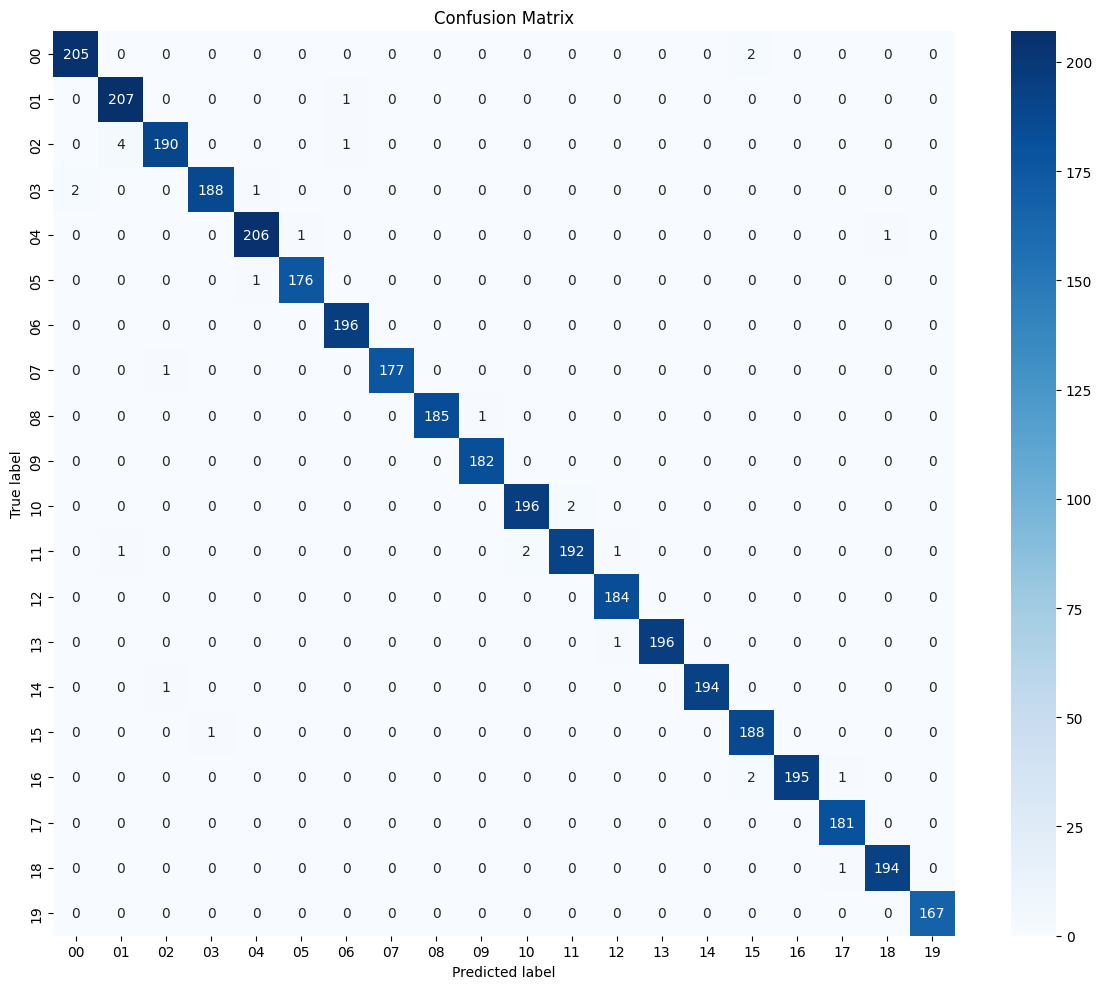

findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the foll

归一化混淆矩阵


findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the following families were found: fonts-wqy-zenhei
findfont: Generic family 'sans-serif' not found because none of the foll

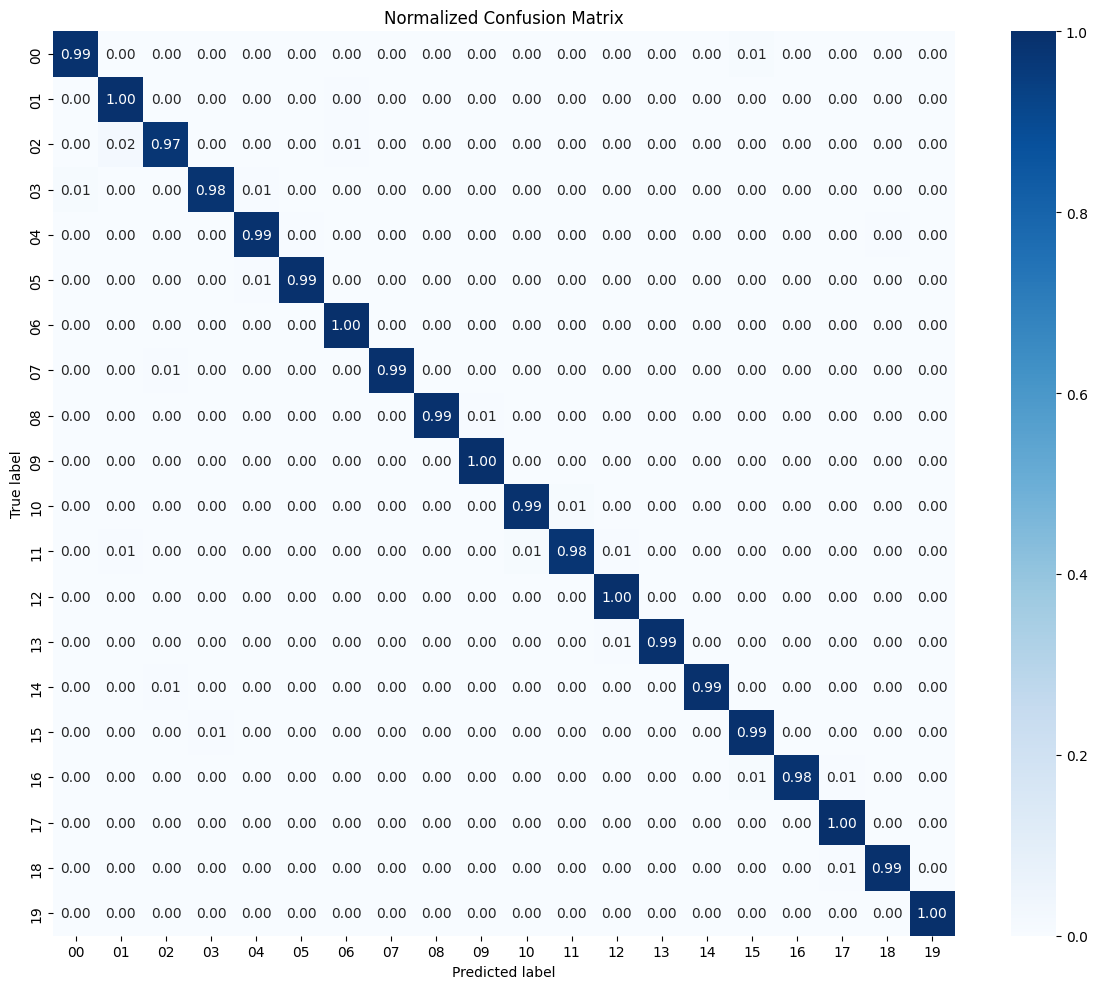

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("归一化混淆矩阵")
    else:
        print("未归一化混淆矩阵")

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap, xticklabels=classes, yticklabels=classes)

    if title:
        plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


def evaluate_and_plot(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for mfcc, labels in dataloader:
            mfcc = mfcc.permute(0, 2, 1).to(device)
            labels = labels.squeeze().to(device)

            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 绘制非归一化混淆矩阵
    plot_confusion_matrix(all_labels, all_preds, classes=class_names, title="Confusion Matrix")

    # 绘制归一化混淆矩阵
    plot_confusion_matrix(all_labels, all_preds, classes=class_names, normalize=True, title="Normalized Confusion Matrix")

    return all_labels, all_preds


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeechRecognizer().to(device)
model.load_state_dict(torch.load("model.pth"))

# 执行评估和绘图
class_names = list(VOCAB.keys())
true_labels, pred_labels = evaluate_and_plot(model, val_loader, device, class_names)